In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point

import sys
sys.path.insert(0, '../src/processing/')
import tools
import os.path
import definitions

In [2]:
commareas = gpd.read_file("../data/raw/geofences/Boundaries - Community Areas (current).geojson")
commareas.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


In [3]:
losq = commareas[commareas.community == "LOGAN SQUARE"]

In [4]:
patterns = tools.load_patterns(73, False)
patterns.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir
0,41.913547,-87.633030,287.0,4,1451,Clark & Lasalle,S,36853.0,2169,Westbound
1,41.915565,-87.634193,1024.0,6,1905,Clark & Lincoln,S,36853.0,2169,Westbound
2,41.916687,-87.634905,1470.0,8,1906,Clark & Wisconsin,S,36853.0,2169,Westbound
3,41.918220,-87.636368,2359.0,14,13180,Armitage & Clark,S,36853.0,2169,Westbound
4,41.918212,-87.639118,3097.0,17,4084,Armitage & Lincoln/Sedgwick,S,36853.0,2169,Westbound


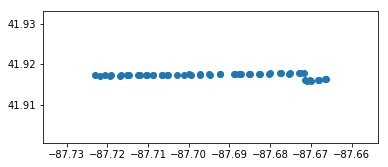

In [5]:
geometry = [Point(xy) for xy in zip(patterns.lon, patterns.lat)]
patterns_gdf = gpd.GeoDataFrame(patterns, geometry=geometry, crs={'init': 'epsg:4326'})
losq_stops = gpd.sjoin(patterns_gdf, losq, how="inner", op="intersects")
losq_stops.plot()

In [6]:
tw_path = os.path.join(definitions.TRAVELS_WAITS_DIR, "{}_{}_{}_travels_waits.csv".format(73, "Westbound", "201901"))
travels_waits = pd.read_csv(tw_path)
#travels_waits.pid = travels_waits.pid.astype(int)
travels_waits["bins"] = pd.cut(travels_waits.decimal_time, np.arange(5, 24, 2), labels=np.arange(5, 23, 2), right=False)
travels_waits.drop(travels_waits[~travels_waits.origin.isin(losq_stops.stpid)].index, inplace=True)
travels_waits.head()

,1451,1905,1906,13180,4084,4085,4086,4087,4088,4089,...,4138,3883,14179,start_date,pid,tatripid,decimal_time,wait|14179,origin,bins
27526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.07,24.83,25.00,2019-01-01,2169,2,7.22,19.72,4095,7
27527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.62,20.47,20.72,2019-01-01,2169,7,7.53,28.32,4095,7
27528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.70,NaN,NaN,2019-01-01,2169,8,8.02,18.57,4095,7
27529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.43,22.18,22.33,2019-01-01,2169,9,8.32,17.25,4095,7
27530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.88,24.45,24.73,2019-01-01,2169,10,8.62,22.60,4095,7


In [7]:
waits_cols = travels_waits.columns[travels_waits.columns.str.contains("wait\|")]

In [8]:
grouped = travels_waits.groupby(["start_date", "pid", "tatripid", "bins"])[waits_cols].mean().reset_index()
filtered = losq_stops.groupby('pid').rtdir.first().reset_index()
grouped = grouped.merge(filtered, how='inner', on='pid')

In [9]:
grouped.groupby(["rtdir", "bins"])[waits_cols].count()

wait|14179
rtdir     bins            
Westbound 5            150
          7            324
          9            340
          11           226
          13           239
          15           325
          17           312
          19           165
          21            96

In [10]:
masked = grouped.copy()
masked[waits_cols] = (masked[waits_cols] < 2)
masked.groupby(["rtdir", "bins"])[waits_cols].sum()

wait|14179
rtdir     bins            
Westbound 5            0.0
          7            4.0
          9            3.0
          11           0.0
          13           0.0
          15           3.0
          17           6.0
          19           0.0
          21           0.0

In [11]:
masked.groupby(["rtdir", "bins"])[waits_cols].sum() / grouped.groupby(["rtdir", "bins"])[waits_cols].count()

wait|14179
rtdir     bins            
Westbound 5       0.000000
          7       0.012346
          9       0.008824
          11      0.000000
          13      0.000000
          15      0.009231
          17      0.019231
          19      0.000000
          21      0.000000

In [12]:
print grouped.groupby(["rtdir", "bins"])[waits_cols].mean()

                wait|14179
rtdir     bins            
Westbound 5      19.781730
          7      12.873016
          9      12.917799
          11     19.827373
          13     18.559086
          15     13.885295
          17     14.573795
          19     20.832703
          21     22.952353


In [13]:
dates = [
    "201901",
    "201902",
    "201903",
    "201904",
]

rts = ["49","X49","52","53","56","73","74","76","82"]

In [ ]:
losq_mean_waits = []
losq_bunching = []
cta_holidays = pd.DatetimeIndex(definitions.HOLIDAYS)

for rt in rts:
    patterns = tools.load_patterns(rt, False)
    geometry = [Point(xy) for xy in zip(patterns.lon, patterns.lat)]
    patterns_gdf = gpd.GeoDataFrame(patterns, geometry=geometry, crs={'init': 'epsg:4326'})
    losq_stops = gpd.sjoin(patterns_gdf, losq, how="inner", op="intersects")
    
    pid_rtdir_mapping = losq_stops.groupby('pid').rtdir.first().reset_index()
    colname_map = {"wait|{}".format(stpid): "wait|{}".format(stpnm) for stpid, stpnm in zip(patterns.stpid, patterns.stpnm)}
    for rtdir in losq_stops.rtdir.unique():
        monthly_mean_waits = []
        monthly_bunching = []
        for date in dates[:1]:
            tws = tools.load_travels_waits(rt, rtdir.lower(), date)
            tws.drop(tws[(tws.start_date.dt.dayofweek >= 5) | tws.start_date.isin(cta_holidays)].index, inplace=True)
            tws["bins"] = pd.cut(tws.decimal_time, np.arange(5, 24, 2), labels=np.arange(5, 23, 2), right=False)
            tws.drop(tws[~tws.origin.isin(losq_stops.stpid)].index, inplace=True)
            
            waits_cols = tws.columns[tws.columns.str.contains("wait\|")]
            
            grouped = tws.groupby(["start_date", "pid", "tatripid", "bins"])[waits_cols].mean().reset_index()
            grouped = grouped.merge(pid_rtdir_mapping, how='inner', on='pid')
            monthly_mean_waits.append(grouped)
            
            bunched = grouped.copy()
            bunched[waits_cols] = (bunched[waits_cols] < 2)
            monthly_tot = grouped.groupby(["rtdir", "bins"])[waits_cols].count()
            monthly_incidents = bunched.groupby(["rtdir", "bins"])[waits_cols].sum()
            monthly_bunching.append((monthly_incidents, monthly_tot))
        df = pd.concat(monthly_mean_waits, ignore_index=True)
        rt_mean = df.groupby(["rtdir", "bins"])[waits_cols].mean()
        losq_mean_waits.append(rt_mean)

        incidents, tot = zip(*monthly_bunching)
        rt_bunching = sum(incidents)/sum(tot)
        losq_bunching.append(rt_bunching)
        
        print rt, rtdir
        print rt_mean.rename(columns=colname_map)
        print "bus bunching statistics"
        print rt_bunching.rename(columns=colname_map)

49 Northbound
                 wait|Western & Berwyn Terminal
rtdir      bins                                
Northbound 5                          13.924632
           7                          13.042781
           9                           9.909347
           11                          8.466208
           13                          8.456972
           15                         10.681285
           17                         10.010314
           19                          9.242289
           21                         20.085757
bus bunching statistics
                 wait|Western & Berwyn Terminal
rtdir      bins                                
Northbound 5                           0.010695
           7                           0.022936
           9                           0.089552
           11                          0.083333
           13                          0.089337
           15                          0.086643
           17                          0.140741
  